# 위치 인코딩

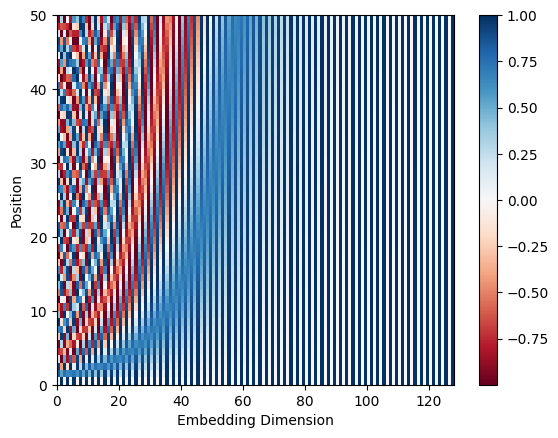

In [1]:
import math
import torch
from torch import nn
from matplotlib import pyplot as plt

# 위치 인코딩 클래스 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1): # d_model: 임베딩 차원, max_len: 최대 시퀀스 길이, dropout: 드롭아웃 비율
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)  # 드롭아웃 계층 설정

        # 위치 벡터 생성, 각 위치마다 임베딩 차원을 계산
        position = torch.arange(max_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)         # 각 차원마다 다른 주기로 나눌 수 있는 값
        )

        # 위치 임베딩 초기화함, max_len x 1 x d_model 형태로 0으로 채워진 텐서 생성
        pe = torch.zeros(max_len, 1, d_model)

        # 위치별로 짝수 인덱스 - 사인 값, 홀수 인덱스 - 코사인 값 적용
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe)

    # 순전파 단계 정의
    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

# PositionalEncoding 인스턴스 생성
encoding = PositionalEncoding(d_model=128, max_len=50)

# 위치 인코딩 시각화
plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

# 트랜스포머 모델 번역

In [2]:
# 1. 언어 모델 및 데이터셋 준비
!python -m spacy download de  # 독일어 모델 다운로드
!python -m spacy download en  # 영어 모델 다운로드

# from torchtext.datasets import multi30k
# multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
# multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
# multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 28.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependenc

In [5]:
pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00


In [6]:
from torchtext.datasets import multi30k

#대체 url
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

OSError: /usr/local/lib/python3.10/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [7]:
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# 토큰 생성 함수 정의
def generate_tokens(text_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}  # 언어 인덱스 매핑
    for text in text_iter:
        yield token_transform[language](text[language_index[language]])         # 지정 언어에 해당하는 토큰화 적용 후 생성

# 소스 및 타겟 언어 설정, 특수 토큰 정의
SRC_LANGUAGE = "de"  # 소스 언어: 독일어
TGT_LANGUAGE = "en"  # 타겟 언어: 영어
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3  # 특수 토큰 인덱스
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]  # 특수 토큰 정의

# 언어별 토크나이저 설정
token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
}
print("Token Transform:")
print(token_transform)

# 언어별로 단어 집합 구축
vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Multi30k 데이터셋 학습에 사용
    train_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),  # 토큰 생성기 사용
        min_freq=1,  # 최소 빈도 기준 설정
        specials=special_symbols,  # 특수 토큰 추가
        special_first=True
    )

# 각 언어별ㅀ 기본 인덱스를 미지정 토큰으로 설정
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

print("Vocab Transform:")
print(vocab_transform)

OSError: /usr/local/lib/python3.10/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [8]:
# 2. 위치 인코딩과 임베딩 클래스 정의

import math
import torch
from torch import nn

# 위치 인코딩 클래스 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 위치와 변환 비율 계산
        position = torch.arange(max_len).unsqueeze(1)  # 위치 행렬 생성
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # 위치별 sine과 cosine 함수를 적용 -> 위치 인코딩 행렬 생성
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]  # 입력에 위치 인코딩을 추가 후 드롭아웃 적용
        return self.dropout(x)

# 토큰 임베딩 클래스 정의
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)  # 임베딩 레이어
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [9]:
# 3. Seq2Seq Transformer 모델 정의

class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()

        # 인코더와 디코더에 토큰 임베딩과 위치 인코딩을 적용
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)  # 소스 임베딩
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)  # 타겟 임베딩
        self.positional_encoding = PositionalEncoding(d_model=emb_size, max_len=max_len, dropout=dropout)

        # Transformer 모델 정의
        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,  # 헤드 수
            num_encoder_layers=num_encoder_layers,  # 인코더 레이어 수
            num_decoder_layers=num_decoder_layers,  # 디코더 레이어 수
            dim_feedforward=dim_feedforward,  # 피드포워드 차원
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)  # 출력층 정의

    # 모델의 순전파 정의
    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        # 입력 토큰에 위치 인코딩 추가 후 임베딩
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        # Transformer를 통해 예측값 생성
        outs = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)  # 출력층에 통과하여 최종 예측값 반환

    # 인코딩 및 디코딩 부분 정의
    def encode(self, src, src_mask):
        # 인코더를 사용해 소스 시퀀스 인코딩
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        # 디코더를 사용해 타겟 시퀀스 디코딩
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [10]:
# 4. 모델 초기화 및 학습 설정

from torch import optim

# 하이퍼파라미터와 모델 정의
BATCH_SIZE = 128  # 배치 크기
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Seq2Seq Transformer 모델 초기화
model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),  # 소스 단어집합 크기
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),  # 타겟 단어집합 크기
    dim_feedforward=512,
).to(DEVICE)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)  # PAD 토큰 무시
optimizer = optim.Adam(model.parameters())  # Adam 옵티마이저 설정

# 모델 계층 구조 출력
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

NameError: name 'vocab_transform' is not defined

# 문장 생성을 위한 GPT-2 모델의 구조

In [12]:
from transformers import GPT2LMHeadModel

# GPT-2 모델을 사전 학습된 가중치로 불러오기
model = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path="gpt2")

# 모델의 계층 구조를 탐색하며 출력
for main_name, main_module in model.named_children():
    # 최상위 계층 이름 출력
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        # 두 번째 계층 이름 출력
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            # 세 번째 계층 이름 출력
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                # 네 번째 계층 이름 출력
                print("│  │  └", sssub_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer
└ wte
└ wpe
└ drop
└ h
│  └ 0
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 1
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 2
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 3
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 4
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 5
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 6
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 7
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 8
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 9
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 10
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
│  └ 11
│  │  └ ln_1
│  │  └ attn
│  │  └ ln_2
│  │  └ mlp
└ ln_f
lm_head


# GPT-2를 이용한 문장 생성

In [13]:
!pip install --upgrade torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
from transformers import pipeline

# 텍스트 생성 파이프라인을 'gpt2' 모델로 초기화
generator = pipeline(task="text-generation", model="gpt2")

# 텍스트 생성 실행: 주어진 문장으로부터 최대 20 토큰까지 생성
outputs = generator(
    text_inputs="Machine learning is",  # 입력 문장
    max_length=20,  # 생성할 최대 토큰 수
    num_return_sequences=3,  # 반환할 생성된 문장의 개수
    pad_token_id=generator.tokenizer.eos_token_id  # 패딩에 사용될 토큰 ID (모델 종료 토큰 ID)
)

# 생성된 문장 출력
print(outputs)

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
cannot import name 'is_torchvision_v2_available' from 'transformers.utils.import_utils' (/usr/local/lib/python3.10/dist-packages/transformers/utils/import_utils.py)

# GPT-2 모델 실습

In [16]:
!pip uninstall -y torch torchtext

Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0


In [17]:
!pip install torch torchtext

  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchtext-0.18.0-cp310-cp310-manylinux1_x86_64.whl.metadata (7.9 kB)
Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl (906.4 MB)
Using cached torchtext-0.18.0-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.


In [18]:
import torch
from torchtext.datasets import CoLA
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# collator 함수 정의(전처리 시 필요)
def collator(batch, tokenizer, device):
    source, labels, texts = zip(*batch) # 배치 데이터 언패킹해 소스, 라벨, 텍스트로 분리함

    # 텍스트 데이터를 토크나이저로 토큰화 및 패딩 처리
    tokenized = tokenizer(
        texts,
        padding="longest",  # 가장 긴 문장에 맞춰 패딩
        truncation=True,  # 지정된 최대 길이에 맞게 자르기
        return_tensors="pt"  # PyTorch 텐서로 반환
    )

    # 토큰화 결과 입력: IDs와 어텐션 마스크로 분리하고 디바이스에 올림
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    labels = torch.tensor(labels, dtype=torch.long).to(device)  # 라벨을 텐서로 변환하여 디바이스에 올림
    return input_ids, attention_mask, labels  # 입력 IDs, 어텐션 마스크, 라벨 반환

# CoLA 데이터셋을 리스트로 변환
train_data = list(CoLA(split="train"))  # 학습 데이터
valid_data = list(CoLA(split="dev"))    # 검증 데이터
test_data = list(CoLA(split="test"))    # 테스트 데이터

# 'GPT2' 모델의 토크나이저 불러오고 패딩 토큰 설정
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2에 'pad_token'이 없어서 'eos_token'을 대신 설정

# 학습 시 필요한 하이퍼파라미터 설정
epochs = 3  # 에폭 수
batch_size = 16  # 배치 크기
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU 사용 여부 확인

# 데이터 로더 생성
train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    collate_fn=lambda x: collator(x, tokenizer, device),  # collator 함수로 배치를 전처리
    shuffle=True,  # 학습 데이터는 매 에폭마다 셔플
)
valid_dataloader = DataLoader(
    valid_data, batch_size=batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)
test_dataloader = DataLoader(
    test_data, batch_size=batch_size, collate_fn=lambda x: collator(x, tokenizer, device)
)

# 데이터셋 크기 출력
print("Train Dataset Length :", len(train_data))
print("Valid Dataset Length :", len(valid_data))
print("Test Dataset Length :", len(test_data))

OSError: /usr/local/lib/python3.10/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [1]:
from torch import optim
from transformers import GPT2ForSequenceClassification


# GPT-2 모델: 이진 분류
model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",  # 사전 학습된 'GPT 2' 모델 불러오기
    num_labels=2  # 분류 클래스 수 설정 (이진 분류)
).to(device)  # 모델을 지정한 장치 (GPU 또는 CPU)로 이동

# 패딩 토큰 ID를 종료 토큰 ID와 동일하게 설정 (GPT-2는 패딩 토큰 ID가 기본적으로 설정되어 있지 않음)
model.config.pad_token_id = model.config.eos_token_id

# Adam 옵티마이저 설정 (학습률 5e-5)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [2]:
import numpy as np
from torch import nn

# 정확도 계산 함수 정의
def calc_accuracy(preds, labels):
    # 예측 결과에서 가장 높은 확률을 가진 클래스 선택
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # 예측과 실제 라벨이 일치하는 비율을 계산하여 정확도 반환
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 학습 함수 정의
def train(model, optimizer, dataloader):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0  # 학습 손실 초기화

    for input_ids, attention_mask, labels in dataloader:
        # 모델에 입력 데이터를 전달하여 출력 계산
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # 출력에서 손실 계산
        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        loss.backward()  # 손실에 대한 역전파 수행
        optimizer.step()  # 옵티마이저가 가중치를 업데이트

    # 에폭별 평균 손실 계산
    train_loss = train_loss / len(dataloader)
    return train_loss

# 평가 함수 정의
def evaluation(model, dataloader):
    with torch.no_grad():  # 평가 중에는 기울기 계산 비활성화
        model.eval()  # 모델을 평가 모드로 설정
        criterion = nn.CrossEntropyLoss()  # 손실 함수 정의
        val_loss, val_accuracy = 0.0, 0.0  # 검증 손실 및 정확도 초기화

        for input_ids, attention_mask, labels in dataloader:
            # 모델에 입력 데이터 전달하여 출력 계산
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits

            # 손실 계산
            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()

            # 정확도 계산
            accuracy = calc_accuracy(logits, label_ids)

            val_loss += loss
            val_accuracy += accuracy

    # 에폭별 평균 검증 손실과 정확도 계산
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    return val_loss, val_accuracy

# 모델 학습 및 평가 루프
best_loss = 10000  # 초기 최고 손실 설정
for epoch in range(epochs):
    # 학습 손실 계산
    train_loss = train(model, optimizer, train_dataloader)

    # 검증 손실 및 정확도 계산
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    # 현재 에폭의 검증 손실이 가장 낮을 경우 모델 가중치 저장
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/GPT2ForSequenceClassification.pt")
        print("Saved the model weights")

NameError: name 'epochs' is not defined

In [3]:
# GPT-2 이진 분류 모델을 사전 학습된 가중치로 불러와 초기화 후, 저장된 가중치 로드

import torch

# CUDA가 사용 가능한지 확인하고, 가능하다면 GPU 사용, 그렇지 않다면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT2ForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="gpt2",  # 사전 학습된 'gpt2' 모델 사용
    num_labels=2  # 분류할 클래스 수 (이진 분류)
).to(device)  # 모델을 지정한 장치 (GPU 또는 CPU)로 이동

#GPT-2에 기본 패딩 토큰 ID가 없어서 패딩 토큰 ID를 종료 토큰 ID와 동일하게 설정
model.config.pad_token_id = model.config.eos_token_id

# 저장된 모델 가중치 불러오기
model.load_state_dict(torch.load("../models/GPT2ForSequenceClassification.pt"))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_accuracy = evaluation(model, test_dataloader)

# 테스트 손실과 정확도 출력
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

## BERT 모델 실습

In [5]:
!pip install Korpora

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.8 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
df = pd.DataFrame(corpus.test).sample(20000, random_state=42)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:00, 85.2MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 43.4MB/s]                            


In [2]:
# 데이터프레임을 무작위로 섞어 학습, 검증, 테스트 세트로 분할
train, valid, test = np.split(
    df.sample(frac=1, random_state=42),  # 데이터를 무작위로 섞음 (random_state로 시드 고정)
    [int(0.6 * len(df)), int(0.8 * len(df))]  # 60%, 80% 인덱스 위치를 기준으로 분할
)

# 학습 데이터의 상위 5개 행을 Markdown 형식으로 출력
print(train.head(5).to_markdown())

# 각 데이터 세트의 크기 출력
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")

|       | text                                                     |   label |
|------:|:---------------------------------------------------------|--------:|
| 26891 | 역시 코믹액션은 성룡, 홍금보, 원표 삼인방이 최고지!!     |       1 |
| 25024 | 점수 후하게 줘야것네 별 반개~                            |       0 |
| 11666 | 오랜만에 느낄수 있는 [감독] 구타욕구.                    |       0 |
| 40303 | 본지는 좀 됬지만 극장서 돈주고 본게 아직까지 아까운 영화 |       0 |
| 18010 | 징키스칸이란 소재를 가지고 이것밖에 못만드냐             |       0 |
Training Data Size : 12000
Validation Data Size : 4000
Testing Data Size : 4000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

# 데이터셋 생성 함수 정의
def make_dataset(data, tokenizer, device):
    # 텍스트 데이터를 토크나이저로 토큰화 및 패딩 처리
    tokenized = tokenizer(
        text=data.text.tolist(),  # 데이터의 텍스트 열을 리스트로 변환
        padding="longest",  # 가장 긴 문장에 맞춰 패딩
        truncation=True,  # 지정된 최대 길이에 맞게 자름
        return_tensors="pt"  # PyTorch 텐서로 반환
    )
    # 토큰화 결과를 입력 IDs와 어텐션 마스크로 분리하고, 디바이스에 올림
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)

    # 라벨 데이터를 텐서로 변환하여 디바이스에 올림
    labels = torch.tensor(data.label.values, dtype=torch.long).to(device)

    # 입력 IDs, 어텐션 마스크, 라벨을 TensorDataset으로 묶어서 반환
    return TensorDataset(input_ids, attention_mask, labels)

# 데이터 로더 생성 함수 정의
def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)  # 샘플러 설정
    # 데이터셋을 주어진 샘플러와 배치 크기로 DataLoader 생성
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader

# 학습에 필요한 하이퍼파라미터 설정
epochs = 5  # 학습 에폭 수
batch_size = 32  # 배치 크기
device = "cuda" if torch.cuda.is_available() else "cpu"

# BERT 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",
    do_lower_case=False  # 대소문자 구분 설정
)

# 학습, 검증, 테스트 데이터셋 생성 및 데이터로더 초기화
train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)  # 학습 데이터는 랜덤 샘플링 사용

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)  # 검증 데이터는 순차적 샘플링 사용

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)  # 테스트 데이터는 순차적 샘플링 사용

# 첫 번째 학습 데이터셋 출력
print(train_dataset[0])

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

(tensor([   101,  58466,   9812, 118956, 119122,  59095,  10892,   9434, 118888,
           117,   9992,  40032,  30005,    117,   9612,  37824,   9410,  12030,
         42337,  10739,  83491,  12508,    106,    106,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,

In [6]:
from torch import optim
from transformers import BertForSequenceClassification
import torch

# CUDA가 사용 가능한지 확인하고, 가능하다면 GPU 사용, 그렇지 않다면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT 이진 분류 모델 초기화 (사전 학습된 가중치 사용)
model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",  # 멀티언어 사전 학습 BERT 모델 불러오기
    num_labels=2  # 분류할 클래스 수 (이진 분류)
).to(device)  # 모델을 지정된 장치로 이동

# AdamW 옵티마이저 설정 (가중치 감쇠 적용)
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-5,  # 학습률
    eps=1e-8  # 수치 안정성을 위한 작은 값
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 모델의 계층 구조를 탐색하며 출력하는 코드
for main_name, main_module in model.named_children():
    # 최상위 계층 이름 출력
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        # 두 번째 계층 이름 출력
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            # 세 번째 계층 이름 출력
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                # 네 번째 계층 이름 출력
                print("│  │  └", sssub_name)

bert
└ embeddings
│  └ word_embeddings
│  └ position_embeddings
│  └ token_type_embeddings
│  └ LayerNorm
│  └ dropout
└ encoder
│  └ layer
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  │  └ 6
│  │  └ 7
│  │  └ 8
│  │  └ 9
│  │  └ 10
│  │  └ 11
└ pooler
│  └ dense
│  └ activation
dropout
classifier


In [ ]:
import numpy as np
from torch import nn

# 예측 정확도를 계산하는 함수 정의
def calc_accuracy(preds, labels):
    # 예측 결과에서 가장 높은 확률을 가진 클래스 선택
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # 예측과 실제 라벨이 일치하는 비율을 계산하여 정확도 반환
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 모델 학습 함수 정의
def train(model, optimizer, dataloader):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0  # 학습 손실 초기화

    # 배치별로 학습 데이터셋을 순회
    for input_ids, attention_mask, labels in dataloader:
        # 모델에 입력 데이터를 전달하여 출력 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # 출력에서 손실 계산
        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화
        loss.backward()  # 손실에 대한 역전파 수행
        optimizer.step()  # 옵티마이저가 가중치 업데이트

    # 에폭별 평균 학습 손실 계산
    train_loss = train_loss / len(dataloader)
    return train_loss

# 모델 평가 함수 정의
def evaluation(model, dataloader):
    with torch.no_grad():  # 평가 중에는 기울기 계산 비활성화
        model.eval()  # 모델을 평가 모드로 설정
        criterion = nn.CrossEntropyLoss()  # 손실 함수 정의
        val_loss, val_accuracy = 0.0, 0.0  # 검증 손실 및 정확도 초기화

        # 배치별로 검증 데이터셋을 순회
        for input_ids, attention_mask, labels in dataloader:
            # 모델에 입력 데이터 전달하여 출력 계산
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            # 손실 계산
            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()

            # 정확도 계산
            accuracy = calc_accuracy(logits, label_ids)

            val_loss += loss
            val_accuracy += accuracy

    # 에폭별 평균 검증 손실과 정확도 계산
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    return val_loss, val_accuracy

# 모델 학습 및 평가 루프
best_loss = 10000  # 초기 최저 검증 손실 설정
for epoch in range(epochs):
    # 학습 손실 계산
    train_loss = train(model, optimizer, train_dataloader)

    # 검증 손실 및 정확도 계산
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    # 현재 에폭의 검증 손실이 가장 낮을 경우 모델 가중치 저장
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/BertForSequenceClassification.pt")
        print("Saved the model weights")

In [ ]:
from transformers import BertForSequenceClassification

# BERT 이진 분류 모델을 사전 학습된 가중치로 불러와 초기화하고, 저장된 가중치 로드
model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-multilingual-cased",  # 멀티언어 사전 학습 BERT 모델 사용
    num_labels=2  # 분류할 클래스 수 (이진 분류)
).to(device)  # 모델을 지정된 장치(GPU 또는 CPU)로 이동

# 저장된 모델 가중치 로드
model.load_state_dict(torch.load("../models/BertForSequenceClassification.pt"))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_accuracy = evaluation(model, test_dataloader)

# 테스트 손실과 정확도 출력
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

## BART 모델 실습

In [ ]:
!pip install evaluate rouge_score absl-py

In [ ]:
news = load_dataset("argilla/news-summary", split="test")
# 데이터셋에서 필요한 열 샘플링 후, prediction 열의 텍스트 추출
df = news.to_pandas().sample(5000, random_state=42)[["text", "prediction"]]
df["prediction"] = df["prediction"].map(lambda x: x[0]["text"])

# 데이터셋을 학습, 검증, 테스트 세트로 60%, 20%, 20% 비율로 분할
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

In [ ]:
import torch
from transformers import BartTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

# 데이터셋을 토크나이저로 처리하여 TensorDataset 형식으로 반환
def make_dataset(data, tokenizer, device):
    # 입력 텍스트 토큰화
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt",
        max_length=1024
    )
    labels = []
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)

    # 요약 텍스트 토큰화 후 패딩
    for target in data.prediction:
        labels.append(tokenizer.encode(target, return_tensors="pt").squeeze())
    labels = pad_sequence(labels, batch_first=True, padding_value=-100).to(device)

    return TensorDataset(input_ids, attention_mask, labels)

# DataLoader 생성 함수 정의
def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader

# 학습에 필요한 하이퍼파라미터 설정
epochs = 5
batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

# BART 토크나이저 불러오기
tokenizer = BartTokenizer.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
)

# 학습, 검증, 테스트 데이터셋 생성 및 데이터로더 초기화
train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

# 첫 번째 학습 데이터셋 출력
print(train_dataset[0])

In [ ]:
from torch import optim
from transformers import BartForConditionalGeneration

# BART 모델 불러오기
model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)

# AdamW 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

# 모델 계층 구조 출력
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)


In [ ]:
import numpy as np
import evaluate

# ROUGE-2 점수 계산 함수 정의
def calc_rouge(preds, labels):
    preds = preds.argmax(axis=-1)  # 예측 결과에서 argmax 사용하여 토큰 추출
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)  # 패딩 위치는 토크나이저 패딩 토큰으로 변경

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE-2 점수 계산
    rouge2 = rouge_score.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    return rouge2["rouge2"]

# 학습 함수 정의
def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    for input_ids, attention_mask, labels in dataloader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

# 평가 함수 정의
def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss, val_rouge = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            loss = outputs.loss

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            rouge = calc_rouge(logits, label_ids)

            val_loss += loss
            val_rouge += rouge

    val_loss = val_loss / len(dataloader)
    val_rouge = val_rouge / len(dataloader)
    return val_loss, val_rouge

# ROUGE 점수 계산 모듈 불러오기
rouge_score = evaluate.load("rouge", tokenizer=tokenizer)

# 학습 및 검증 루프
best_loss = 10000
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Rouge {val_accuracy:.4f}")

    # 검증 손실이 최소일 때 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/BartForConditionalGeneration.pt")
        print("Saved the model weights")

In [ ]:
# BART 모델 초기화 및 저장된 가중치 불러오기
model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
model.load_state_dict(torch.load("../models/BartForConditionalGeneration.pt"))

# 테스트 데이터셋 평가
test_loss, test_rouge_score = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test ROUGE-2 Score : {test_rouge_score:.4f}")

In [ ]:
from transformers import pipeline

# 요약 파이프라인 설정
summarizer = pipeline(
    task="summarization",
    model=model,
    tokenizer=tokenizer,
    max_length=54,
    device="cpu"
)

# 테스트 데이터셋에서 일부 샘플을 출력
for index in range(5):
    news_text = test.text.iloc[index]
    summarization = test.prediction.iloc[index]
    predicted_summarization = summarizer(news_text)[0]["summary_text"]
    print(f"정답 요약문 : {summarization}")
    print(f"모델 요약문 : {predicted_summarization}\n")

## KoELECTRA 모델 실습

In [ ]:
import numpy as np
import pandas as pd
from Korpora import Korpora

# NSMC 코퍼스를 로드하고, 테스트 데이터셋에서 20000개의 샘플을 추출
corpus = Korpora.load("nsmc")
df = pd.DataFrame(corpus.test).sample(20000, random_state=42)

# 데이터를 학습, 검증, 테스트 세트로 60%, 20%, 20% 비율로 분할
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

# 학습 데이터 일부와 각 데이터셋 크기 출력
print(train.head(5).to_markdown())
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")

In [ ]:
# 데이터셋 생성 및 데이터로더 정의

import torch
from transformers import ElectraTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

# 데이터셋을 토크나이저로 처리하여 TensorDataset 형식으로 반환
def make_dataset(data, tokenizer, device):
    # 입력 텍스트 토큰화
    tokenized = tokenizer(
        text=data.text.tolist(),
        padding="longest",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)

    # 라벨을 텐서로 변환하고 장치로 이동
    labels = torch.tensor(data.label.values, dtype=torch.long).to(device)
    return TensorDataset(input_ids, attention_mask, labels)

# DataLoader 생성 함수 정의
def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader

# 하이퍼파라미터 설정
epochs = 5
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# Electra 토크나이저 초기화
tokenizer = ElectraTokenizer.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    do_lower_case=False,
)

# 학습, 검증, 테스트 데이터셋 및 데이터로더 생성
train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

# 첫 번째 학습 데이터셋 출력
print(train_dataset[0])

In [ ]:
# 모델 초기화 및 옵티마이저 설정

from torch import optim
from transformers import ElectraForSequenceClassification

# Electra 이진 분류 모델 불러오기
model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    num_labels=2
).to(device)

# AdamW 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# 모델의 계층 구조 출력
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

In [ ]:
# 정확도 계산 함수 및 학습/평가 루프 정의

import numpy as np
from torch import nn

# 예측 정확도 계산 함수 정의
def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 학습 함수 정의
def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    # 데이터셋을 배치 단위로 순회하며 학습
    for input_ids, attention_mask, labels in dataloader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # 손실 계산
        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

    # 배치 평균 학습 손실 반환
    train_loss = train_loss / len(dataloader)
    return train_loss

# 평가 함수 정의
def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        val_loss, val_accuracy = 0.0, 0.0

        # 데이터셋을 배치 단위로 순회하며 평가
        for input_ids, attention_mask, labels in dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            # 손실 및 정확도 계산
            loss = criterion(logits, labels)
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            accuracy = calc_accuracy(logits, label_ids)

            val_loss += loss
            val_accuracy += accuracy

    # 배치 평균 검증 손실 및 정확도 반환
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    return val_loss, val_accuracy

In [ ]:
#모델 학습 및 평가 루프

# 초기 최저 손실 설정
best_loss = 10000
for epoch in range(epochs):
    # 학습 손실 계산
    train_loss = train(model, optimizer, train_dataloader)

    # 검증 손실 및 정확도 계산
    val_loss, val_accuracy = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Accuracy {val_accuracy:.4f}")

    # 검증 손실이 최소일 때 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/ElectraForSequenceClassification.pt")
        print("Saved the model weights")

In [ ]:
#테스트 평가 및 결과 출력
from transformers import ElectraForSequenceClassification

# 저장된 모델 불러오기 및 가중치 로드
model = ElectraForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="monologg/koelectra-base-v3-discriminator",
    num_labels=2
).to(device)
model.load_state_dict(torch.load("../models/ElectraForSequenceClassification.pt"))

# 테스트 데이터셋 평가
test_loss, test_accuracy = evaluation(model, test_dataloader)

# 테스트 손실과 정확도 출력
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")

## T5 모델 실습

In [ ]:
#데이터셋 로드 및 분할
import numpy as np
from datasets import load_dataset

# 데이터셋 불러와 무작위로 5000개의 샘플을 추출하여 텍스트와 요약문으로 구성된 DataFrame 생성
news = load_dataset("argilla/news-summary", split="test")
df = news.to_pandas().sample(5000, random_state=42)[["text", "prediction"]]

# 입력 텍스트 앞에 'summarize:'라는 프롬프트를 추가해 T5 모델이 요약 작업을 수행하도록 설정
df["text"] = "summarize: " + df["text"]

# 요약문 데이터에서 텍스트만 추출
df["prediction"] = df["prediction"].map(lambda x: x[0]["text"])

# 데이터를 60%, 20%, 20% 비율로 학습, 검증, 테스트 세트로 분할
train, valid, test = np.split(
    df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

# 데이터 일부 출력
print(f"Source News : {train.text.iloc[0][:200]}")
print(f"Summarization : {train.prediction.iloc[0][:50]}")
print(f"Training Data Size : {len(train)}")
print(f"Validation Data Size : {len(valid)}")
print(f"Testing Data Size : {len(test)}")

In [ ]:
# 데이터셋 전처리 및 데이터로더 정의
import torch
from transformers import T5Tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

# 입력 및 레이블 데이터를 토큰화하고 TensorDataset 형식으로 반환하는 함수
def make_dataset(data, tokenizer, device):
    # 입력 텍스트를 토큰화하고 최대 길이로 패딩
    source = tokenizer(
        text=data.text.tolist(),
        padding="max_length",
        max_length=128,
        pad_to_max_length=True,
        truncation=True,
        return_tensors="pt"
    )

    # 요약문(타겟 텍스트)을 토큰화하고 최대 길이로 패딩
    target = tokenizer(
        text=data.prediction.tolist(),
        padding="max_length",
        max_length=128,
        pad_to_max_length=True,
        truncation=True,
        return_tensors="pt"
    )

    # 토큰화된 입력 IDs와 어텐션 마스크, 레이블 IDs 및 레이블 마스크 생성
    source_ids = source["input_ids"].squeeze().to(device)
    source_mask = source["attention_mask"].squeeze().to(device)
    target_ids = target["input_ids"].squeeze().to(device)
    target_mask = target["attention_mask"].squeeze().to(device)
    return TensorDataset(source_ids, source_mask, target_ids, target_mask)

# DataLoader 생성 함수 정의
def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader

# 하이퍼파라미터 설정
epochs = 5
batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

# T5 모델 토크나이저 불러오기
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# 학습, 검증, 테스트 데이터셋 및 데이터로더 생성
train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

# 첫 번째 학습 데이터셋 출력 및 토큰 예시 출력
print(next(iter(train_dataloader)))
print(tokenizer.convert_ids_to_tokens(21603))
print(tokenizer.convert_ids_to_tokens(10))

In [ ]:
# 모델 초기화 및 옵티마이저 설정
from torch import optim
from transformers import T5ForConditionalGeneration

# T5 모델 불러오기 (요약문 생성을 위한 조건부 생성 모델)
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# AdamW 옵티마이저 설정 (가중치 감쇠 적용)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [ ]:
# 학습 및 평가 함수 정의
import numpy as np
from torch import nn

# 학습 함수 정의
def train(model, optimizer, dataloader):
    model.train()
    train_loss = 0.0

    # 데이터셋을 배치 단위로 순회하며 학습
    for source_ids, source_mask, target_ids, target_mask in dataloader:
        # 디코더 입력 및 레이블 생성
        decoder_input_ids = target_ids[:, :-1].contiguous()
        labels = target_ids[:, 1:].clone().detach()
        labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100  # 패딩 토큰 위치를 -100으로 설정하여 무시

        # 모델에 입력 데이터를 전달하고 손실 계산
        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            decoder_input_ids=decoder_input_ids,
            labels=labels,
        )

        loss = outputs.loss
        train_loss += loss.item()

        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

    # 배치 평균 학습 손실 반환
    train_loss = train_loss / len(dataloader)
    return train_loss

# 평가 함수 정의
def evaluation(model, dataloader):
    with torch.no_grad():  # 평가 중에는 기울기 계산 비활성화
        model.eval()
        val_loss = 0.0

        # 데이터셋을 배치 단위로 순회하며 평가
        for source_ids, source_mask, target_ids, target_mask in dataloader:
            # 디코더 입력 및 레이블 생성
            decoder_input_ids = target_ids[:, :-1].contiguous()
            labels = target_ids[:, 1:].clone().detach()
            labels[target_ids[:, 1:] == tokenizer.pad_token_id] = -100  # 패딩 토큰 위치를 -100으로 설정하여 무시

            # 모델에 입력 데이터를 전달하고 손실 계산
            outputs = model(
                input_ids=source_ids,
                attention_mask=source_mask,
                decoder_input_ids=decoder_input_ids,
                labels=labels,
            )

            loss = outputs.loss
            val_loss += loss

    # 배치 평균 검증 손실 반환
    val_loss = val_loss / len(dataloader)
    return val_loss

In [ ]:
# 모델 학습 및 평가 루프
best_loss = 10000  # 초기 최저 손실 설정
for epoch in range(epochs):
    # 학습 손실 계산
    train_loss = train(model, optimizer, train_dataloader)

    # 검증 손실 계산
    val_loss = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

    # 검증 손실이 최소일 때 모델 저장
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/T5ForConditionalGeneration.pt")
        print("Saved the model weights")

In [ ]:
# 테스트 평가 및 요약 생성 예시
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 기울기 계산 비활성화
    for source_ids, source_mask, target_ids, target_mask in test_dataloader:
        # 테스트 데이터셋에서 요약문 생성
        generated_ids = model.generate(
            input_ids=source_ids,
            attention_mask=source_mask,
            max_length=128,  # 생성할 최대 토큰 길이
            num_beams=3,  # 빔 탐색 개수
            repetition_penalty=2.5,  # 반복 억제 설정
            length_penalty=1.0,  # 길이 패널티 설정
            early_stopping=True,  # 조기 종료 설정
        )

        # 생성된 요약문과 실제 요약문을 디코딩하여 비교
        for generated, target in zip(generated_ids, target_ids):
            pred = tokenizer.decode(
                generated, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            actual = tokenizer.decode(
                target, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            print("Generated Headline Text:", pred)
            print("Actual Headline Text   :", actual)
        break  # 첫 배치만 출력